<a href="https://colab.research.google.com/github/zainab9271/AI-Dojo_Machine_learning_bootcamp/blob/main/Assignment_05_Deep_Learning_Zainab_Mahmood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 05: Deep Learning

This Week's assignment is to train Deep Learning models on the `cats and dogs` images dataset to accurately classify the animal in the image.

Before starting copy this file and work on your own copy by following the below steps: <br>
`File > Save Copy in Drive`. Then add your name to the file (e.g., Assignment 05: Deep Learning - Muntadher Alkaabi).


**Submission Deadline: Thursday, 2/17/2022 at 3:00 PM**

**Requirements:**

1. Import all necessary libraries for the Deep Learning project.
2. Download the dataset (the link is provided below).
3. Make sure to convert the target into one hot vector.
4. Create data pipeline with data augmentation.
    1. Read images using tensorflow.
    2. Make sure the pixels values are scaled between (`0-1`).
    3. Resize the images to (224,224).
    4. Apply multiple image augmentation on the data.
    5. Make sure the augmentation image pixels are scaled between (`0-1`). 
5. Plot the images.
6. Train CNN models (try ResNet architecture).
**Note:** use sub-class to create the ResNet model.


7. Use multiple Transfer Learning models.<br>
**Note:** make sure to chooses the right model with input shape (224,224,3).

8. Use the right evaluation metrics to choose the best model (write down your choice of the best model).


**Note:** To get the best performance from the model, manually tune the hyperparameters of each model. 

Find relevant links below:<br>
[Dataset](https://www.kaggle.com/aseemdandgaval/23-pet-breeds-image-classification)

[Submission Form](https://forms.gle/GGELZHoiB5pBtFXi9)<br>
[How to use kaggle with colab](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

Good luck and feel free to ask any questions in the or on the Questions channel.

# 1- Import all necessary libraries for the Deep Learning project

In [ ]:
# import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import os
import glob
import tqdm
import cv2
import imghdr

# 2- Download the dataset

In [ ]:
# download the required dataset from kaggle 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d aseemdandgaval/23-pet-breeds-image-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 790M/794M [00:06<00:00, 153MB/s]
100% 794M/794M [00:06<00:00, 133MB/s]


In [ ]:
!unzip /content/23-pet-breeds-image-classification.zip

Archive:  /content/23-pet-breeds-image-classification.zip
  inflating: Pet_Breeds/abyssinian/abyssinian_1.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_10.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_100.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_101.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_102.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_103.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_104.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_105.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_106.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_107.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_108.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_109.jpeg  
  inflating: Pet_Breeds/abyssinian/abyssinian_11.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_110.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_111.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_112.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_113

## Check for Corrupted Images

In [ ]:
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        if f_path not in bad_images:
                            bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/Pet_Breeds'
good_exts=['jpg', 'jpeg'] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  abyssinian
processing class directory  shiba inu
processing class directory  golden retriever
processing class directory  dachshund
processing class directory  maine coon
processing class directory  labrador
processing class directory  chihuahua
processing class directory  corgi
processing class directory  pug
processing class directory  boxer
processing class directory  siamese cat
processing class directory  ragdoll cat
processing class directory  beagle
processing class directory  pomeranian
processing class directory  sphynx
processing class directory  american shorthair
processing class directory  german shepherd
processing class directory  persian cat
processing class directory  husky
processing class directory  rottwiler
processing class directory  mumbai cat
file  /content/Pet_Breeds/mumbai cat/mumbai cat_71.jpg  is not a valid image file
processing class directory  bulldog
processing class directory  yorkshire terrier
improper image files are listed

### Remove Bad Images

In [ ]:
for img in bad_file_list:
    os.remove(img)

## Create DataFrame of Images Path and Labels

In [ ]:
def create_dataframe(data_path):
    labels = []
    images_path = []
    folders = os.listdir(data_path)
    for folderIndex in tqdm.tqdm(range(len(folders))):
        for image_path in glob.glob(data_path + '/' + folders[folderIndex] + '/*'):
            images_path.append(image_path)
            labels.append(folders[folderIndex])

    df = pd.DataFrame({'images_path': images_path, 'labels': labels})
    return df

dataset = create_dataframe('/content/Pet_Breeds')
dataset

100%|██████████| 23/23 [00:00<00:00, 514.52it/s]


,images_path,labels
0,/content/Pet_Breeds/abyssinian/abyssinian_114.jpg,abyssinian
1,/content/Pet_Breeds/abyssinian/abyssinian_47.jpg,abyssinian
2,/content/Pet_Breeds/abyssinian/abyssinian_145.jpg,abyssinian
3,/content/Pet_Breeds/abyssinian/abyssinian_103.jpg,abyssinian
4,/content/Pet_Breeds/abyssinian/abyssinian_85.jpg,abyssinian
...,...,...
3723,/content/Pet_Breeds/yorkshire terrier/yorkshir...,yorkshire terrier
3724,/content/Pet_Breeds/yorkshire terrier/yorkshir...,yorkshire terrier
3725,/content/Pet_Breeds/yorkshire terrier/yorkshir...,yorkshire terrier
3726,/content/Pet_Breeds/yorkshire terrier/yorkshir...,yorkshire terrier


## Tokenize the labels

In [ ]:
def tokenizer(column):
    word_index = {}
    index_word = {}
    for index, word in enumerate(column.unique()):
        word_index[word] = index
        index_word[index] = word
    return word_index, index_word

labels_WordToIndex, labels_indexToWord = tokenizer(dataset.labels)

print(labels_WordToIndex)
print(labels_indexToWord)

{'abyssinian': 0, 'shiba inu': 1, 'golden retriever': 2, 'dachshund': 3, 'maine coon': 4, 'labrador': 5, 'chihuahua': 6, 'corgi': 7, 'pug': 8, 'boxer': 9, 'siamese cat': 10, 'ragdoll cat': 11, 'beagle': 12, 'pomeranian': 13, 'sphynx': 14, 'american shorthair': 15, 'german shepherd': 16, 'persian cat': 17, 'husky': 18, 'rottwiler': 19, 'mumbai cat': 20, 'bulldog': 21, 'yorkshire terrier': 22}
{0: 'abyssinian', 1: 'shiba inu', 2: 'golden retriever', 3: 'dachshund', 4: 'maine coon', 5: 'labrador', 6: 'chihuahua', 7: 'corgi', 8: 'pug', 9: 'boxer', 10: 'siamese cat', 11: 'ragdoll cat', 12: 'beagle', 13: 'pomeranian', 14: 'sphynx', 15: 'american shorthair', 16: 'german shepherd', 17: 'persian cat', 18: 'husky', 19: 'rottwiler', 20: 'mumbai cat', 21: 'bulldog', 22: 'yorkshire terrier'}


In [ ]:
dataset.labels = dataset.labels.map(labels_WordToIndex)
dataset

,images_path,labels
0,/content/Pet_Breeds/abyssinian/abyssinian_114.jpg,0
1,/content/Pet_Breeds/abyssinian/abyssinian_47.jpg,0
2,/content/Pet_Breeds/abyssinian/abyssinian_145.jpg,0
3,/content/Pet_Breeds/abyssinian/abyssinian_103.jpg,0
4,/content/Pet_Breeds/abyssinian/abyssinian_85.jpg,0
...,...,...
3723,/content/Pet_Breeds/yorkshire terrier/yorkshir...,22
3724,/content/Pet_Breeds/yorkshire terrier/yorkshir...,22
3725,/content/Pet_Breeds/yorkshire terrier/yorkshir...,22
3726,/content/Pet_Breeds/yorkshire terrier/yorkshir...,22


## Plot the Data

In [ ]:
def plot_data(yticks_range):
    plt.rcParams['font.size'] = '14'
    plt.figure(figsize=(20,5))
    plt.xticks(ticks=range(23), labels=list(labels_WordToIndex.keys()), rotation=45, ha='right', rotation_mode='anchor')
    plt.xlabel('Pets Breeds')
    plt.yticks(ticks=yticks_range)
    plt.ylabel('Images Count')
    plt.bar(list(labels_WordToIndex.keys()), np.bincount(dataset.labels))
    plt.show()

### Before Balancing

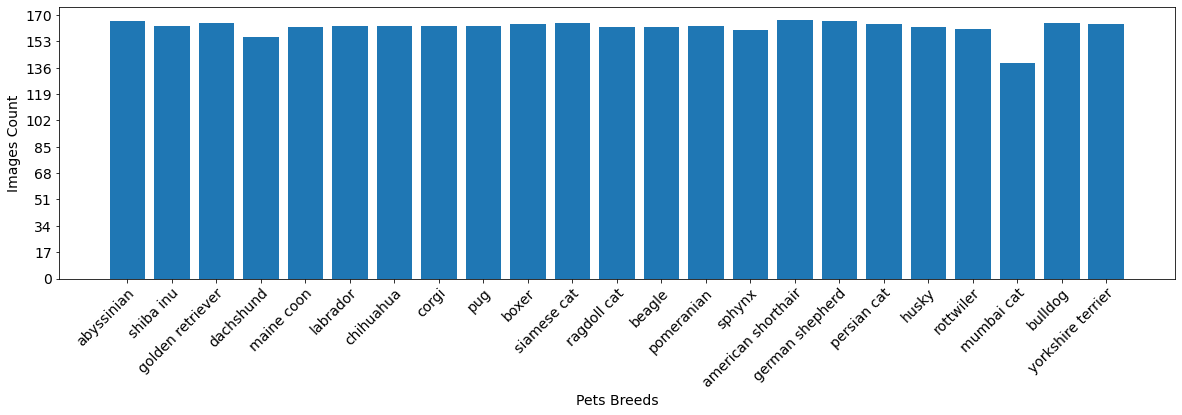

In [ ]:
plot_data(yticks_range=range(0, 171, 17))

#### Images Count in each Class

In [ ]:
def get_images_count(labels):
    print('Number of Images in each Class:')
    df = pd.DataFrame(columns=['class', 'images_count'])
    for index, imgCount in enumerate(np.bincount(labels)):
        df = df.append({'class': labels_indexToWord[index], 'images_count': imgCount}, ignore_index=True)
    return df

In [ ]:
df = get_images_count(dataset.labels)
df

Number of Images in each Class:


,class,images_count
0,abyssinian,166
1,shiba inu,163
2,golden retriever,165
3,dachshund,156
4,maine coon,162
5,labrador,163
6,chihuahua,163
7,corgi,163
8,pug,163
9,boxer,164


### Balance the Data

In [ ]:
labels_imgCounts = np.bincount(dataset.labels)      # get the number of images in each class
except_label = labels_imgCounts.argmin()            # get the index of a class which has less images

dropped_data = pd.DataFrame(columns=['images_path', 'labels'])

labels = dataset.labels.unique()
labels = np.delete(labels, except_label)

for label in labels:
    num_drop = len(dataset.loc[dataset.labels == label]) - labels_imgCounts[except_label]
    drop_index = dataset.loc[dataset.labels == label].index[-num_drop:]
    df = dataset.loc[drop_index]
    dropped_data = dropped_data.append(df, ignore_index = True)
    dataset.drop(drop_index, inplace=True)

dataset.reset_index(drop=True, inplace=True)
print('dropped data shape = ', dropped_data.shape)
print('balanced dataset shape = ', dataset.shape)

dropped data shape =  (531, 2)
balanced dataset shape =  (3197, 2)


### After Balancing

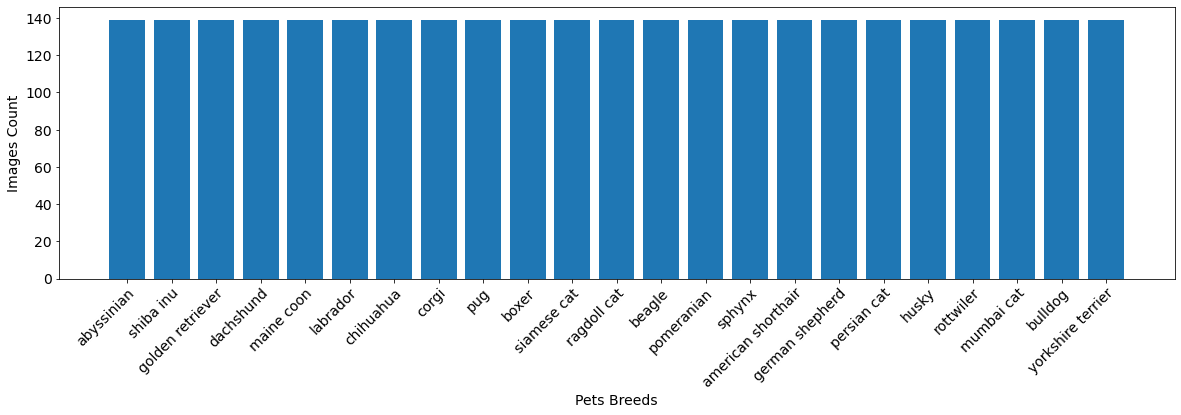

In [ ]:
plot_data(yticks_range=range(0, 150, 20))

#### Images Count in each Class

In [ ]:
df = get_images_count(dataset.labels)
df

Number of Images in each Class:


,class,images_count
0,abyssinian,139
1,shiba inu,139
2,golden retriever,139
3,dachshund,139
4,maine coon,139
5,labrador,139
6,chihuahua,139
7,corgi,139
8,pug,139
9,boxer,139


## Split the Data

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(dataset.images_path, dataset.labels, test_size=0.2, stratify=dataset.labels, random_state=42)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
# check the shape of the following (x_train, y_train and x_test, y_test)

print(f'x_train shape = {x_train.shape}')
print(f'y_train shape = {y_train.shape}')
print(f'x_test  shape = {x_test.shape}')
print(f'y_test  shape = {y_test.shape}')

x_train shape = (2557,)
y_train shape = (2557,)
x_test  shape = (640,)
y_test  shape = (640,)


# 3- Make sure to convert the target into one hot vector

In [ ]:
# convert the labels to one hot vector
y_train_hot = tf.one_hot(y_train, depth=len(set(y_train)))
y_test_hot = tf.one_hot(y_test, depth=len(set(y_train)))


# 4- Create Data Pipeline with Data Augmentation


In [ ]:
# read images file from file path
def read_images(x,y):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x, (224,224)) 
    return x, y

def image_aug(x,y):
    x = tf.image.random_flip_left_right(x)
    x= tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x,max_delta=32/255)
    x= tf.image.random_saturation(x,lower=0.5,upper=1.5)
    x = tf.clip_by_value(x,0.0,1.0)
    return x, y


In [ ]:
# create the data pipline 
def dataset_creator(x,y, training = True):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(500)
    data = data.map(read_images, num_parallel_calls = tf.data.AUTOTUNE)
    
    if training:
        data = data.map(image_aug, num_parallel_calls = tf.data.AUTOTUNE)

    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

In [ ]:
train_dataset = dataset_creator(x_train, y_train_hot)
test_dataset = dataset_creator(x_test, y_test_hot, training = False)

# 5- Plot the images 

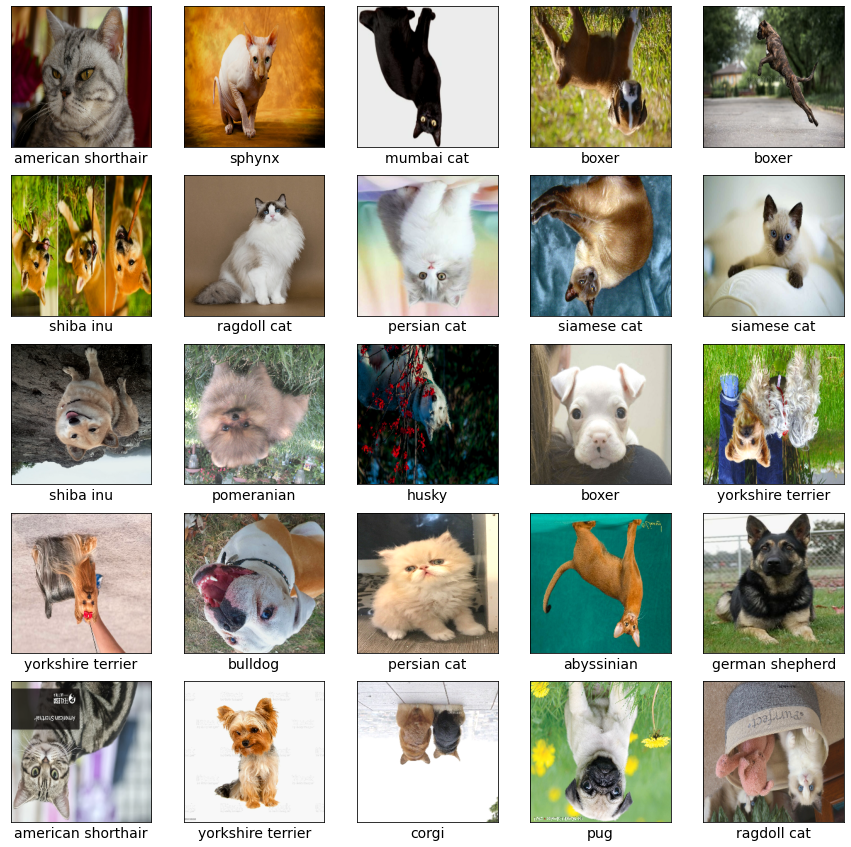

In [ ]:
# plot the augmented images 

for x, y in train_dataset.take(1):
    plt.figure(figsize=(15,15))
    for i in range(25):
        plt.subplot(5,5,i+1) 

        plt.xticks([])  
        plt.yticks([])  

        plt.imshow(x[i]) 

        labelIndex = np.argmax(y[i], axis=-1)
        plt.xlabel(labels_indexToWord[labelIndex])


# 6- Modeling
**Note:**
1. Train CNN models (try ResNet architecture).
1. Make sure to separate each model in a new sub-section.
2. Use multiple Transfer Learning models.
4. Use the right evaluation metrics to choose the best model (write down your choice of the best model).

## CNN Model
### Resnet Blocks 
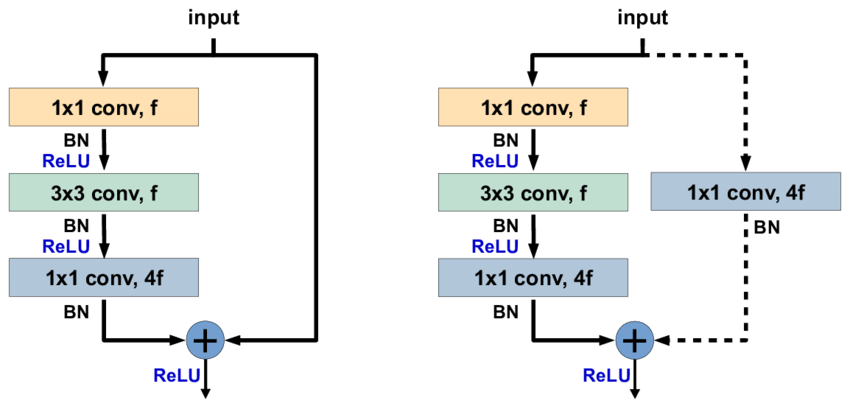

## ResNet

### Identical Residual Block

In [ ]:
class IdenticalBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(IdenticalBlock, self).__init__(**kwargs)
        f1, f2 = filters
        
        self.conv1 = tf.keras.layers.Conv2D(filters=f1, kernel_size=(1,1), use_bias=False, padding='valid')
        self.BN_conv1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=f1, kernel_size=(3,3), use_bias=False, padding='same')
        self.BN_conv2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2D(filters=f2, kernel_size=(3,3), use_bias=False, padding='same')
        self.BN_conv3 = tf.keras.layers.BatchNormalization()

    def build_model(self, input_shape = [224,224, 3]):
        inputs = tf.keras.layers.Input(input_shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

    def call(self, inputs):
        
        x = self.conv1(inputs)
        x = self.BN_conv1(x)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.BN_conv2(x)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.BN_conv3(x)

        add_layer  =tf.keras.layers.Add()([x, inputs])
        add_layer = tf.nn.relu(add_layer)

        return add_layer


identicalBlock = IdenticalBlock([64, 3], name= 'identical_block_1')
identicalBlock.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  192         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Convolutional Residual Block

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        f1, f2 = filters
        
        self.conv1 = tf.keras.layers.Conv2D(filters=f1, kernel_size=(1,1), use_bias=False, padding='valid')
        self.BN_conv1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=f1, kernel_size=(3,3), use_bias=False, padding='same')
        self.BN_conv2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2D(filters=f2, kernel_size=(1,1), strides=strides, use_bias=False, padding='valid')
        self.BN_conv3 = tf.keras.layers.BatchNormalization()

        self.skip_conv = tf.keras.layers.Conv2D(filters = f2, kernel_size=(1,1), strides=strides, use_bias=False, padding='valid')
        self.BN_skip_conv = tf.keras.layers.BatchNormalization()


    def call(self, inputs):
        x_skip = inputs
        x = self.conv1(inputs)
        x = self.BN_conv1(x)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.BN_conv2(x)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.BN_conv3(x)

        x_skip = self.skip_conv(x_skip)
        x_skip = self.BN_skip_conv(x_skip)

        add_layer = tf.keras.layers.Add()([x, x_skip])
        add_layer = tf.nn.relu(add_layer)

        return add_layer

    def build_model(self, input_shape = [224,224, 3]):
            inputs = tf.keras.layers.Input(input_shape)
            return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

conv_block = ConvBlock(filters=[64,128], strides=(1,1), name= 'Conv_Block_1')
conv_block.build_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 224, 224, 64  192         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 224, 224, 64  256        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

### ResNet Model

In [ ]:
tf.keras.backend.clear_session()
class ResNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(ResNet, self).__init__(**kwargs)

        self.input_conv = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), use_bias=False)
        self.BN_input_conv = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPool2D()

        self.identical_block_1 = IdenticalBlock([64,32], name= 'identical_block_1')

        self.identical_block_2 = IdenticalBlock([64,32], name= 'identical_block_2')

        self.conv_block_1 = ConvBlock([128,64], strides=(1,1), name= 'conv_block_1')
        self.maxpool_2 = tf.keras.layers.MaxPool2D()

        self.identical_block_3 = IdenticalBlock([128,64], name= 'identical_block_3')

        self.identical_block_4 = IdenticalBlock([128,64], name= 'identical_block_4')

        self.out = tf.keras.layers.Dense(units=23)


    def call(self, inputs):
        x = self.input_conv(inputs)
        x = self.BN_input_conv(x)
        x = tf.nn.relu(x)
        x = self.maxpool_1(x)

        x = self.identical_block_1(x)
        x = self.identical_block_2(x)
        x = self.conv_block_1(x)
        x = self.maxpool_2(x)
        x = self.identical_block_3(x)
        x = self.identical_block_4(x)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        out = self.out(x)
        out = tf.nn.softmax(out)

        return out

    def build_model(self, input_shape = [224,224, 3]):
            inputs = tf.keras.layers.Input(input_shape)
            return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

model_ResNet = ResNet()
model_ResNet.build_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      2400      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 220, 220, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 identical_block_1 (Identica  (None, 110, 110, 32)     57984 

In [ ]:
model_ResNet.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(), metrics=['acc'])
model_ResNet.fit(train_dataset, epochs=2, validation_data=test_dataset)

Epoch 1/2
80/80 [==============================] - 105s 1s/step - loss: 3.1709 - acc: 0.0864 - val_loss: 3.3721 - val_acc: 0.0437
Epoch 2/2
80/80 [==============================] - 91s 1s/step - loss: 2.9657 - acc: 0.1279 - val_loss: 3.8032 - val_acc: 0.0547


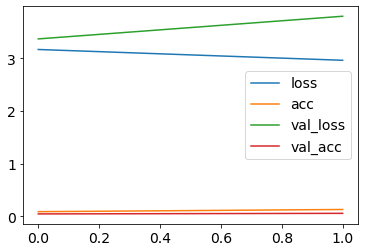

In [ ]:
pd.DataFrame(model_ResNet.history.history).plot()

### Evaluation

In [ ]:
def get_correct_vs_predicted_labels(model):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image, label in test_dataset:   # use dataset.unbatch() with repeat
        # append true labels
        y_true.append(label)
        # compute predictions
        preds = model.predict(image)
        # append predicted labels
        y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)

    correct_labels = np.argmax(correct_labels, axis=-1)
    correct_labels = correct_labels.reshape(-1,1)

    return correct_labels, predicted_labels


In [ ]:
true_labels_RN, pred_labels_RN = get_correct_vs_predicted_labels(model_ResNet)

In [ ]:
acc_ResNet = metrics.accuracy_score(true_labels_RN, pred_labels_RN)
print(f'Accuracy Score = {acc_ResNet}')


Accuracy Score = 0.0546875


## Transfer Learning

In [ ]:
def create_model_by_pretrained(pretrained_model):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = pretrained_model(inputs, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(128,activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    outputs = tf.keras.layers.Dense(23,activation=tf.nn.softmax)(x)

    model = tf.keras.Model(inputs, outputs)
    return model



### DenseNet201

In [ ]:
pretrained_dcnn201 = tf.keras.applications.DenseNet201(include_top=False, input_shape=(224,224,3))
pretrained_dcnn201.trainable = False
pretrained_dcnn201.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

#### Functional Model

In [ ]:
funcmodel_dcnn201 = create_model_by_pretrained(pretrained_model = pretrained_dcnn201)
funcmodel_dcnn201.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 23)                2967      
                                                             

In [ ]:
funcmodel_dcnn201.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(), metrics=['acc'])
funcmodel_dcnn201.fit(train_dataset, epochs=8, validation_data=test_dataset)

Epoch 1/8
80/80 [==============================] - 98s 1s/step - loss: 1.8857 - acc: 0.4603 - val_loss: 0.5950 - val_acc: 0.8609
Epoch 2/8
80/80 [==============================] - 82s 1s/step - loss: 0.9276 - acc: 0.7259 - val_loss: 0.4381 - val_acc: 0.8828
Epoch 3/8
80/80 [==============================] - 86s 1s/step - loss: 0.7684 - acc: 0.7540 - val_loss: 0.4041 - val_acc: 0.8875
Epoch 4/8
80/80 [==============================] - 90s 1s/step - loss: 0.6422 - acc: 0.8041 - val_loss: 0.3420 - val_acc: 0.8953
Epoch 5/8
80/80 [==============================] - 89s 1s/step - loss: 0.5379 - acc: 0.8322 - val_loss: 0.3414 - val_acc: 0.9016
Epoch 6/8
80/80 [==============================] - 87s 1s/step - loss: 0.5083 - acc: 0.8506 - val_loss: 0.3669 - val_acc: 0.8969
Epoch 7/8
80/80 [==============================] - 90s 1s/step - loss: 0.4762 - acc: 0.8502 - val_loss: 0.3446 - val_acc: 0.9031
Epoch 8/8
80/80 [==============================] - 91s 1s/step - loss: 0.4251 - acc: 0.8647 - val

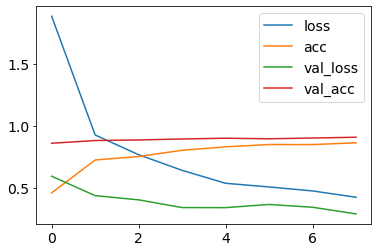

In [ ]:
pd.DataFrame(funcmodel_dcnn201.history.history).plot()

#### Evaluation

In [ ]:
true_labels_dcn, pred_labels_dcn = get_correct_vs_predicted_labels(funcmodel_dcnn201)

In [ ]:
acc_dcn = metrics.accuracy_score(true_labels_dcn, pred_labels_dcn)
print(f'Accuracy Score = {acc_dcn}')


Accuracy Score = 0.909375


### Xception

In [ ]:
pretrained_xception = tf.keras.applications.Xception(include_top=False, input_shape=(224,224,3))
pretrained_xception.trainable = False
pretrained_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

#### Functional Model

In [ ]:
funcmodel_xception = create_model_by_pretrained(pretrained_model = pretrained_xception)
funcmodel_xception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 23)                2967      
                                                             

In [ ]:
funcmodel_xception.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(), metrics=['acc'])
funcmodel_xception.fit(train_dataset, epochs=8, validation_data=test_dataset)

Epoch 1/8
80/80 [==============================] - 89s 1s/step - loss: 1.5147 - acc: 0.5874 - val_loss: 0.4950 - val_acc: 0.8672
Epoch 2/8
80/80 [==============================] - 77s 955ms/step - loss: 0.8476 - acc: 0.7454 - val_loss: 0.3920 - val_acc: 0.8859
Epoch 3/8
80/80 [==============================] - 75s 938ms/step - loss: 0.7407 - acc: 0.7747 - val_loss: 0.3633 - val_acc: 0.8953
Epoch 4/8
80/80 [==============================] - 75s 940ms/step - loss: 0.6571 - acc: 0.7986 - val_loss: 0.3546 - val_acc: 0.8891
Epoch 5/8
80/80 [==============================] - 74s 928ms/step - loss: 0.5832 - acc: 0.8201 - val_loss: 0.3701 - val_acc: 0.8781
Epoch 6/8
80/80 [==============================] - 73s 918ms/step - loss: 0.5229 - acc: 0.8291 - val_loss: 0.3686 - val_acc: 0.8922
Epoch 7/8
80/80 [==============================] - 74s 923ms/step - loss: 0.4682 - acc: 0.8537 - val_loss: 0.3369 - val_acc: 0.8969
Epoch 8/8
21/80 [======>.......................] - ETA: 46s - loss: 0.4299 - ac

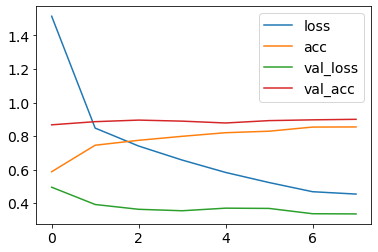

In [ ]:
pd.DataFrame(funcmodel_xception.history.history).plot()

#### Evaluation

In [ ]:
true_labels_xcept, pred_labels_xcept = get_correct_vs_predicted_labels(funcmodel_xception)

In [ ]:
acc_xcept = metrics.accuracy_score(true_labels_xcept, pred_labels_xcept)
print(f'Accuracy Score = {acc_xcept}')


Accuracy Score = 0.9


# The Best Model

In [ ]:
df = pd.DataFrame({'Model':['ResNet', 'DenseNet201', 'Xception'], 'Accuracy':[acc_ResNet, acc_dcn, acc_xcept]})
df

,Model,Accuracy
0,ResNet,0.054688
1,DenseNet201,0.909375
2,Xception,0.900000


<font size='4'>According to accuracy score the best model is </font><font size='5' color='Red'>DenseNet201</font>